# 銅先物ポートフォリオ最適化分析

## 分析目的
このノートブックでは、銅先物の複数限月を用いた最適ポートフォリオ構築を行います。

### 主要分析項目
1. **平均分散最適化**: リスク・リターン効率フロンティアの構築
2. **リスクパリティ戦略**: 各限月のリスク寄与度を均等化
3. **ブラック・リッターマン モデル**: 投資家の市場観を反映した最適化
4. **最小分散ポートフォリオ**: リスク最小化を目指した配分
5. **最大シャープレシオ**: リスク調整後リターンの最大化
6. **動的リバランス戦略**: 時間変化を考慮したポートフォリオ調整

### 投資戦略の実用性
- **多様化効果**: 複数限月保有によるリスク分散
- **相関構造**: 限月間の相関を活用した効率的配分
- **流動性考慮**: 取引可能性を考慮した実務的配分
- **コスト最適化**: 取引コストを考慮した運用方針

In [ ]:
from config.database_config import get_connection_string
import sys
import os
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats, optimize
from sklearn.covariance import LedoitWolf
import warnings

# プロジェクトルートをPythonパスに追加
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)


warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')

# カラーパレット
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'success': '#2E8B57',
    'warning': '#FF6B35',
    'info': '#4ECDC4'
}

print("ライブラリ読み込み完了")

ライブラリ読み込み完了


## データ取得と前処理

### データベース接続とクエリ実行
- 過去1年間の銅先物価格データを取得
- 限月別の価格・出来高・建玉データを整理
- 分析に必要な形式に変換

In [ ]:
def load_copper_data(conn, days=365):
    """銅先物データを取得"""
    query = f"""
    SELECT 
        p.TradeDate,
        t.TenorTypeName,
        p.SettlementPrice,
        p.Volume,
        p.OpenInterest,
        CASE 
            WHEN t.TenorTypeName LIKE 'Generic 1st%' THEN 1
            WHEN t.TenorTypeName LIKE 'Generic 2nd%' THEN 2
            WHEN t.TenorTypeName LIKE 'Generic 3rd%' THEN 3
            WHEN t.TenorTypeName LIKE 'Generic 4th%' THEN 4
            WHEN t.TenorTypeName LIKE 'Generic 5th%' THEN 5
            WHEN t.TenorTypeName LIKE 'Generic 6th%' THEN 6
            WHEN t.TenorTypeName LIKE 'Generic 7th%' THEN 7
            WHEN t.TenorTypeName LIKE 'Generic 8th%' THEN 8
            WHEN t.TenorTypeName LIKE 'Generic 9th%' THEN 9
            WHEN t.TenorTypeName LIKE 'Generic 10th%' THEN 10
            WHEN t.TenorTypeName LIKE 'Generic 11th%' THEN 11
            WHEN t.TenorTypeName LIKE 'Generic 12th%' THEN 12
            ELSE NULL
        END as TenorNumber
    FROM T_CommodityPrice p
    INNER JOIN M_Metal m ON p.MetalID = m.MetalID
    INNER JOIN M_TenorType t ON p.TenorTypeID = t.TenorTypeID
    WHERE 
        m.MetalCode = 'COPPER'
        AND p.TradeDate >= DATEADD(day, -{days}, GETDATE())
        AND p.SettlementPrice IS NOT NULL
        AND p.Volume > 0
    ORDER BY p.TradeDate DESC
    """

    df = pd.read_sql(query, conn)
    df['TradeDate'] = pd.to_datetime(df['TradeDate'])
    df = df.dropna(subset=['TenorNumber'])
    return df


# データベース接続
conn = pyodbc.connect(get_connection_string())
df = load_copper_data(conn, days=365)

# ピボットテーブル作成
price_pivot = df.pivot_table(
    values='SettlementPrice', index='TradeDate', columns='TenorNumber', aggfunc='mean')
volume_pivot = df.pivot_table(
    values='Volume', index='TradeDate', columns='TenorNumber', aggfunc='mean')

# 欠損値処理
price_pivot = price_pivot.fillna(method='ffill').dropna()

# 分析用データの準備
# 十分な取引量がある限月のみ選択
avg_volumes = volume_pivot.mean()
liquid_tenors = avg_volumes[avg_volumes >
                            avg_volumes.quantile(0.3)].index.tolist()
liquid_tenors = [t for t in liquid_tenors if t <= 12]  # 12ヶ月以内の限月

# 流動性のある限月のみでデータを絞る
price_data = price_pivot[liquid_tenors].copy()
returns_data = price_data.pct_change().dropna()

print(
    f"データ期間: {df['TradeDate'].min().date()} - {df['TradeDate'].max().date()}")
print(f"データ件数: {len(df):,}件")
print(f"分析対象限月: {sorted(liquid_tenors)}")
print(f"価格データ形状: {price_data.shape}")
print(f"リターンデータ形状: {returns_data.shape}")

データ期間: 2024-07-05 - 2025-07-04
データ件数: 2,512件
分析対象限月: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0]
価格データ形状: (253, 7)
リターンデータ形状: (252, 7)


## 1. 基本統計・相関分析

### 分析内容
- 各限月の基本統計量（平均リターン、標準偏差、シャープレシオ）
- 限月間の相関マトリックス分析
- 分散共分散行列の推定（Ledoit-Wolf推定法）

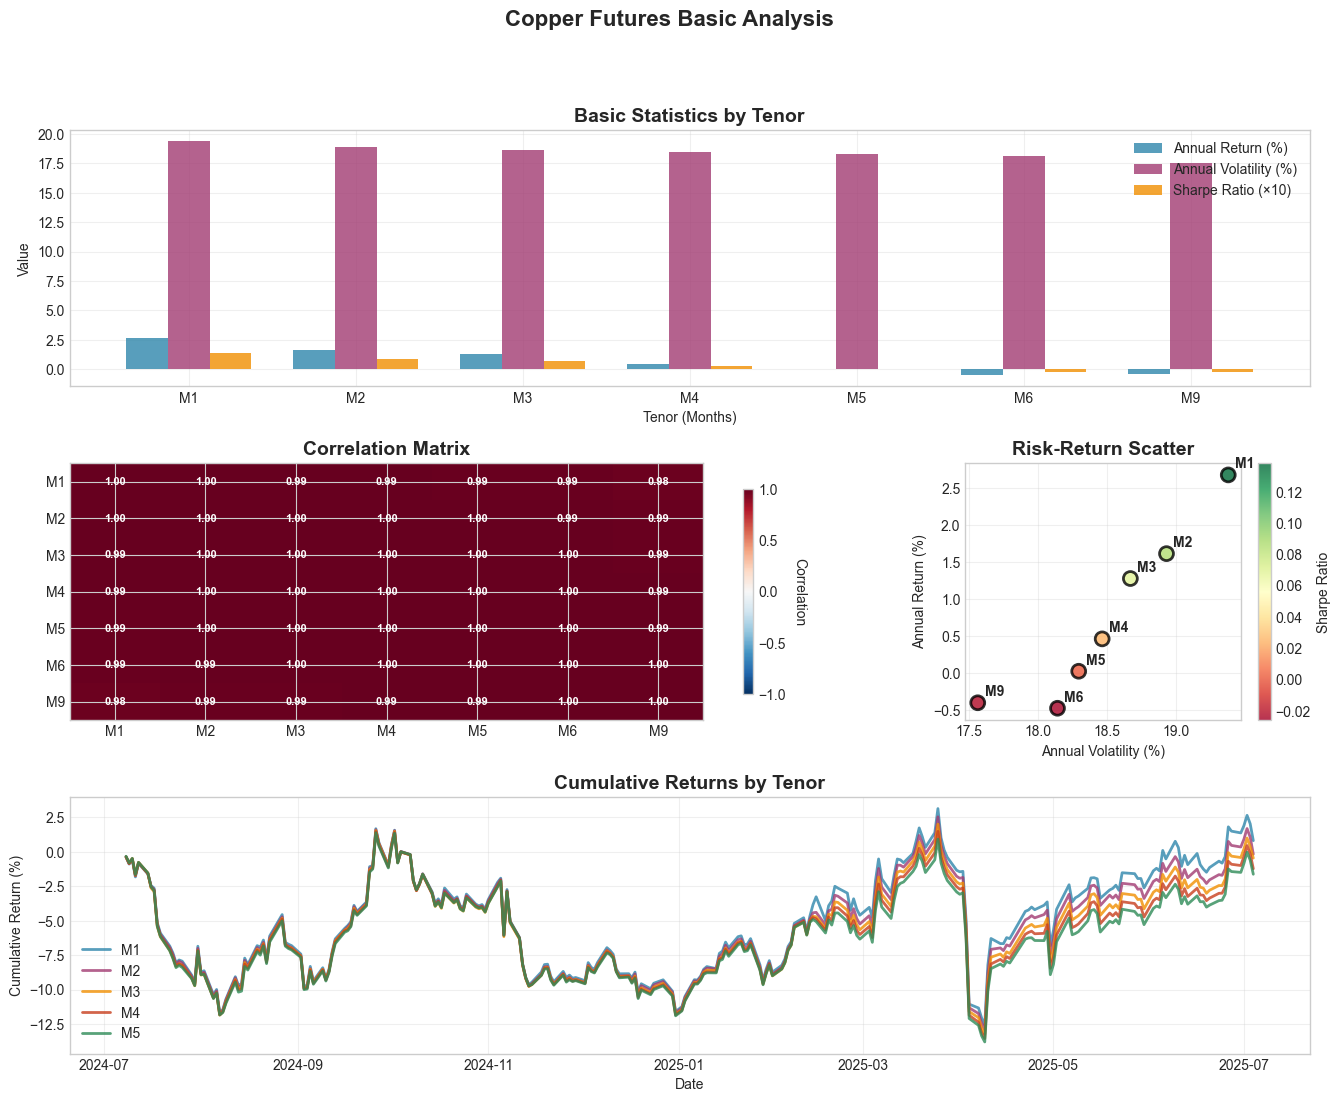


📊 基本統計サマリー
             Ann_Return  Ann_Volatility  Sharpe_Ratio  Skewness  Kurtosis
TenorNumber                                                              
1.0                2.68           19.38          0.14     -0.51      4.19
2.0                1.62           18.93          0.09     -0.55      4.25
3.0                1.28           18.67          0.07     -0.59      4.20
4.0                0.47           18.47          0.03     -0.62      4.24
5.0                0.03           18.30          0.00     -0.63      4.29
6.0               -0.47           18.14         -0.03     -0.63      4.18
9.0               -0.40           17.56         -0.02     -0.64      4.16

📈 最高シャープレシオ: M1 (0.138)
📉 最低リスク: M9 (17.6%)
💹 平均相関: 0.994


In [ ]:
def calculate_basic_stats(returns):
    """基本統計量計算"""
    stats_df = pd.DataFrame(index=returns.columns)

    # 年率換算
    stats_df['Ann_Return'] = returns.mean() * 252 * 100
    stats_df['Ann_Volatility'] = returns.std() * np.sqrt(252) * 100
    stats_df['Sharpe_Ratio'] = stats_df['Ann_Return'] / \
        stats_df['Ann_Volatility']

    # 分布統計
    stats_df['Skewness'] = returns.skew()
    stats_df['Kurtosis'] = returns.kurtosis()

    return stats_df


# 基本統計量計算
basic_stats = calculate_basic_stats(returns_data)

# 相関行列
corr_matrix = returns_data.corr()

# 共分散行列（Ledoit-Wolf推定法）
lw = LedoitWolf()
cov_matrix = pd.DataFrame(
    lw.fit(returns_data.values).covariance_,
    index=returns_data.columns,
    columns=returns_data.columns
) * 252  # 年率換算

# 可視化
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. 基本統計量
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(basic_stats))
width = 0.25

bars1 = ax1.bar(x - width, basic_stats['Ann_Return'], width, label='Annual Return (%)',
                color=COLORS['primary'], alpha=0.8)
bars2 = ax1.bar(x, basic_stats['Ann_Volatility'], width, label='Annual Volatility (%)',
                color=COLORS['secondary'], alpha=0.8)
bars3 = ax1.bar(x + width, basic_stats['Sharpe_Ratio'] * 10, width, label='Sharpe Ratio (×10)',
                color=COLORS['tertiary'], alpha=0.8)

ax1.set_xlabel('Tenor (Months)')
ax1.set_ylabel('Value')
ax1.set_title('Basic Statistics by Tenor', fontsize=14, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'M{int(t)}' for t in basic_stats.index])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 相関行列ヒートマップ
ax2 = fig.add_subplot(gs[1, :2])
im = ax2.imshow(corr_matrix.values, cmap='RdBu_r',
                aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks(range(len(corr_matrix.columns)))
ax2.set_yticks(range(len(corr_matrix.index)))
ax2.set_xticklabels([f'M{int(t)}' for t in corr_matrix.columns])
ax2.set_yticklabels([f'M{int(t)}' for t in corr_matrix.index])
ax2.set_title('Correlation Matrix', fontsize=14, weight='bold')

# 相関値をテキストで表示
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = ax2.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                        ha="center", va="center", color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                        fontsize=8, weight='bold')

cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# 3. リスク・リターン散布図
ax3 = fig.add_subplot(gs[1, 2])
scatter = ax3.scatter(basic_stats['Ann_Volatility'], basic_stats['Ann_Return'],
                      s=100, c=basic_stats['Sharpe_Ratio'], cmap='RdYlGn',
                      alpha=0.8, edgecolors='black', linewidth=2)

for i, txt in enumerate(basic_stats.index):
    ax3.annotate(f'M{int(txt)}', (basic_stats['Ann_Volatility'].iloc[i], basic_stats['Ann_Return'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=10, weight='bold')

ax3.set_xlabel('Annual Volatility (%)')
ax3.set_ylabel('Annual Return (%)')
ax3.set_title('Risk-Return Scatter', fontsize=14, weight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Sharpe Ratio')

# 4. 累積リターン比較
ax4 = fig.add_subplot(gs[2, :])
colors = [COLORS['primary'], COLORS['secondary'],
          COLORS['tertiary'], COLORS['quaternary'], COLORS['success']]
for i, tenor in enumerate(sorted(returns_data.columns)[:5]):
    cum_returns = (1 + returns_data[tenor]).cumprod() - 1
    ax4.plot(cum_returns.index, cum_returns * 100,
             color=colors[i % len(colors)], linewidth=2, label=f'M{int(tenor)}', alpha=0.8)

ax4.set_xlabel('Date')
ax4.set_ylabel('Cumulative Return (%)')
ax4.set_title('Cumulative Returns by Tenor', fontsize=14, weight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Copper Futures Basic Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# 基本統計サマリー
print("\n📊 基本統計サマリー")
print(basic_stats.round(2))
print(
    f"\n📈 最高シャープレシオ: M{int(basic_stats['Sharpe_Ratio'].idxmax())} ({basic_stats['Sharpe_Ratio'].max():.3f})")
print(
    f"📉 最低リスク: M{int(basic_stats['Ann_Volatility'].idxmin())} ({basic_stats['Ann_Volatility'].min():.1f}%)")
print(f"💹 平均相関: {corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().mean():.3f}")

## 2. 効率フロンティア分析

### 分析内容
- 平均分散最適化による効率フロンティア構築
- 最小分散ポートフォリオ
- 最大シャープレシオポートフォリオ
- 制約条件（ロング・オンリー、重み上限）の考慮

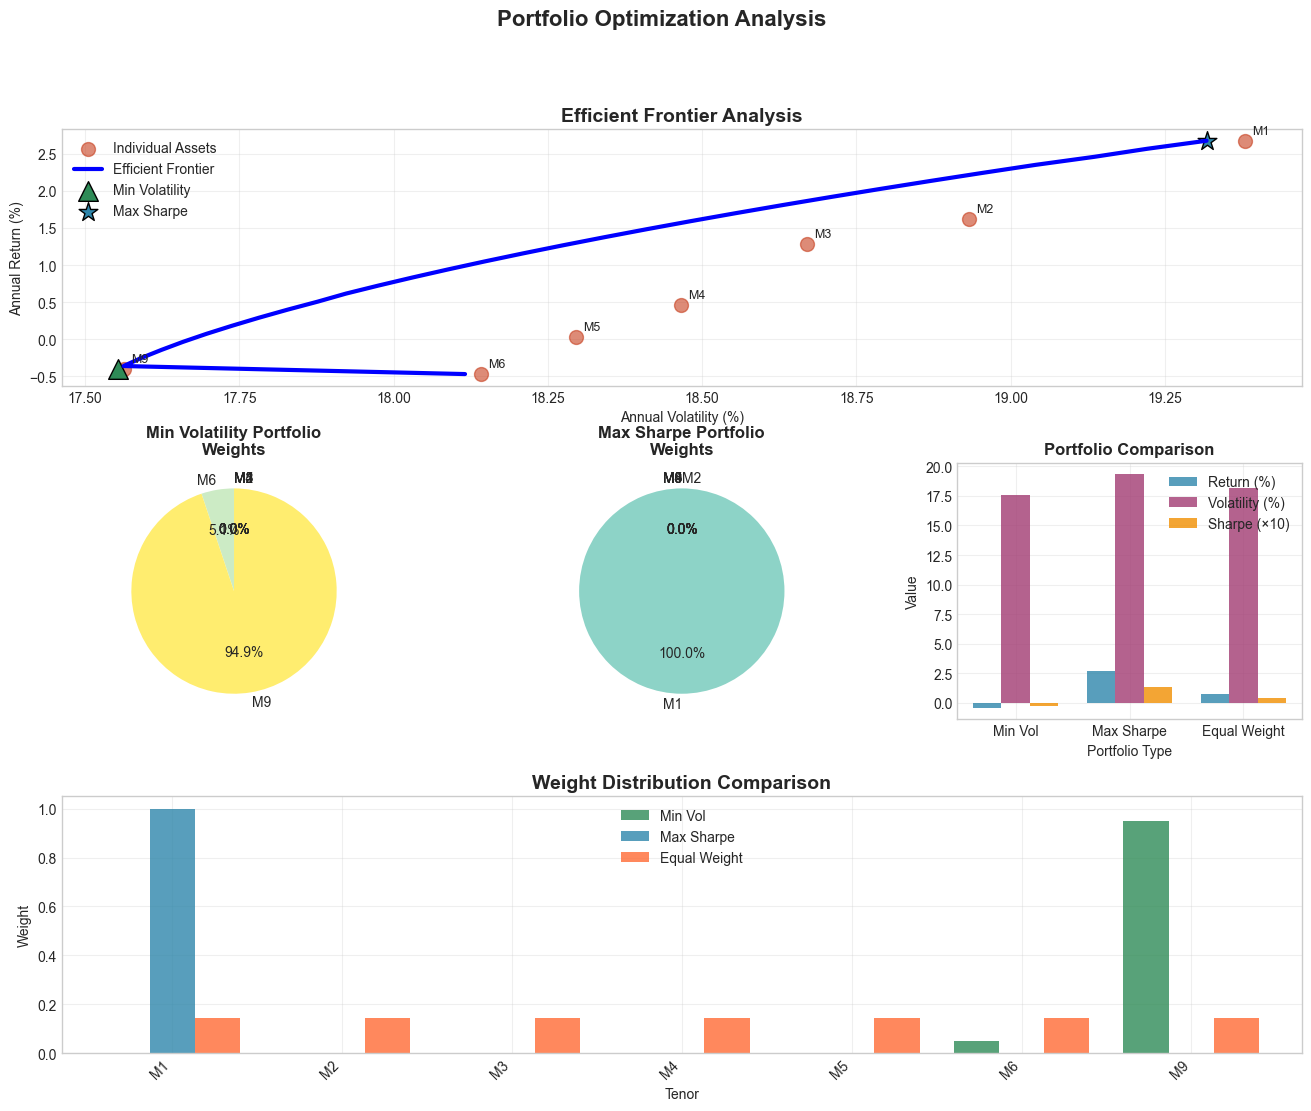


🎯 ポートフォリオ最適化結果

【最小分散ポートフォリオ】
年率リターン: -0.40%
年率ボラティリティ: 17.55%
シャープレシオ: -0.023
構成比:
  M6: 5.1%
  M9: 94.9%

【最大シャープレシオポートフォリオ】
年率リターン: 2.68%
年率ボラティリティ: 19.32%
シャープレシオ: 0.139
構成比:
  M1: 100.0%


In [ ]:
def portfolio_return(weights, returns):
    """ポートフォリオリターン計算"""
    return np.dot(weights, returns)


def portfolio_volatility(weights, cov_matrix):
    """ポートフォリオボラティリティ計算"""
    return np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))


def portfolio_sharpe(weights, returns, cov_matrix, risk_free_rate=0.0):
    """ポートフォリオシャープレシオ計算"""
    port_return = portfolio_return(weights, returns)
    port_vol = portfolio_volatility(weights, cov_matrix)
    return -(port_return - risk_free_rate) / port_vol  # 負値（最小化のため）


def minimize_volatility(returns, cov_matrix):
    """最小分散ポートフォリオ"""
    n = len(returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))

    result = optimize.minimize(portfolio_volatility,
                               np.array([1/n] * n),
                               args=(cov_matrix,),
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)
    return result.x


def maximize_sharpe(returns, cov_matrix):
    """最大シャープレシオポートフォリオ"""
    n = len(returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))

    result = optimize.minimize(portfolio_sharpe,
                               np.array([1/n] * n),
                               args=(returns, cov_matrix),
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)
    return result.x


def efficient_frontier(returns, cov_matrix, num_portfolios=50):
    """効率フロンティア計算"""
    n = len(returns)
    results = np.zeros((4, num_portfolios))

    # リターン範囲設定
    min_ret = returns.min()
    max_ret = returns.max()
    target_returns = np.linspace(min_ret, max_ret, num_portfolios)

    weights_array = np.zeros((num_portfolios, n))

    for i, target in enumerate(target_returns):
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_return(
                x, returns) - target}
        )
        bounds = tuple((0, 1) for _ in range(n))

        result = optimize.minimize(portfolio_volatility,
                                   np.array([1/n] * n),
                                   args=(cov_matrix,),
                                   method='SLSQP',
                                   bounds=bounds,
                                   constraints=constraints)

        if result.success:
            weights_array[i] = result.x
            results[0, i] = target
            results[1, i] = portfolio_volatility(result.x, cov_matrix)
            results[2, i] = results[0, i] / results[1, i]  # Sharpe ratio
            results[3, i] = i

    return results, weights_array


# 期待リターン（年率）
expected_returns = returns_data.mean() * 252

# 最適ポートフォリオ計算
min_vol_weights = minimize_volatility(expected_returns, cov_matrix)
max_sharpe_weights = maximize_sharpe(expected_returns, cov_matrix)

# 効率フロンティア計算
frontier_results, frontier_weights = efficient_frontier(
    expected_returns, cov_matrix, 30)

# 最適ポートフォリオ統計
min_vol_return = portfolio_return(min_vol_weights, expected_returns)
min_vol_vol = portfolio_volatility(min_vol_weights, cov_matrix)
min_vol_sharpe = min_vol_return / min_vol_vol

max_sharpe_return = portfolio_return(max_sharpe_weights, expected_returns)
max_sharpe_vol = portfolio_volatility(max_sharpe_weights, cov_matrix)
max_sharpe_sharpe = max_sharpe_return / max_sharpe_vol

# 可視化
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. 効率フロンティア
ax1 = fig.add_subplot(gs[0, :])

# 個別資産プロット
ax1.scatter(basic_stats['Ann_Volatility'], basic_stats['Ann_Return'],
            s=100, c=COLORS['quaternary'], alpha=0.6, label='Individual Assets')

for i, tenor in enumerate(basic_stats.index):
    ax1.annotate(f'M{int(tenor)}',
                 (basic_stats['Ann_Volatility'].iloc[i],
                  basic_stats['Ann_Return'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

# 効率フロンティア
valid_idx = ~np.isnan(frontier_results[1])
ax1.plot(frontier_results[1][valid_idx] * 100, frontier_results[0][valid_idx] * 100,
         'b-', linewidth=3, label='Efficient Frontier')

# 最適ポートフォリオ
ax1.scatter(min_vol_vol * 100, min_vol_return * 100,
            s=200, c=COLORS['success'], marker='^', label='Min Volatility', edgecolors='black')
ax1.scatter(max_sharpe_vol * 100, max_sharpe_return * 100,
            s=200, c=COLORS['primary'], marker='*', label='Max Sharpe', edgecolors='black')

ax1.set_xlabel('Annual Volatility (%)')
ax1.set_ylabel('Annual Return (%)')
ax1.set_title('Efficient Frontier Analysis', fontsize=14, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 最小分散ポートフォリオ構成
ax2 = fig.add_subplot(gs[1, 0])
tenor_labels = [f'M{int(t)}' for t in returns_data.columns]
colors = plt.cm.Set3(np.linspace(0, 1, len(tenor_labels)))

wedges, texts, autotexts = ax2.pie(min_vol_weights, labels=tenor_labels, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax2.set_title('Min Volatility Portfolio\nWeights', fontsize=12, weight='bold')

# 3. 最大シャープレシオポートフォリオ構成
ax3 = fig.add_subplot(gs[1, 1])
wedges, texts, autotexts = ax3.pie(max_sharpe_weights, labels=tenor_labels, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax3.set_title('Max Sharpe Portfolio\nWeights', fontsize=12, weight='bold')

# 4. ポートフォリオ統計比較
ax4 = fig.add_subplot(gs[1, 2])
portfolio_names = ['Min Vol', 'Max Sharpe', 'Equal Weight']
equal_weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)
equal_return = portfolio_return(equal_weights, expected_returns)
equal_vol = portfolio_volatility(equal_weights, cov_matrix)
equal_sharpe = equal_return / equal_vol

returns_data_plot = [min_vol_return * 100,
                     max_sharpe_return * 100, equal_return * 100]
volatility_data = [min_vol_vol * 100, max_sharpe_vol * 100, equal_vol * 100]
sharpe_data = [min_vol_sharpe, max_sharpe_sharpe, equal_sharpe]

x = np.arange(len(portfolio_names))
width = 0.25

bars1 = ax4.bar(x - width, returns_data_plot, width,
                label='Return (%)', color=COLORS['primary'], alpha=0.8)
bars2 = ax4.bar(x, volatility_data, width, label='Volatility (%)',
                color=COLORS['secondary'], alpha=0.8)
bars3 = ax4.bar(x + width, [s * 10 for s in sharpe_data], width,
                label='Sharpe (×10)', color=COLORS['tertiary'], alpha=0.8)

ax4.set_xlabel('Portfolio Type')
ax4.set_ylabel('Value')
ax4.set_title('Portfolio Comparison', fontsize=12, weight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(portfolio_names)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 重み分布比較
ax5 = fig.add_subplot(gs[2, :])
weight_data = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights,
    'Equal Weight': equal_weights
}, index=tenor_labels)

weight_data.plot(kind='bar', ax=ax5, color=[COLORS['success'], COLORS['primary'], COLORS['warning']],
                 alpha=0.8, width=0.8)
ax5.set_title('Weight Distribution Comparison', fontsize=14, weight='bold')
ax5.set_xlabel('Tenor')
ax5.set_ylabel('Weight')
ax5.legend()
ax5.grid(True, alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Portfolio Optimization Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# 結果サマリー
print("\n🎯 ポートフォリオ最適化結果")
print("\n【最小分散ポートフォリオ】")
print(f"年率リターン: {min_vol_return*100:.2f}%")
print(f"年率ボラティリティ: {min_vol_vol*100:.2f}%")
print(f"シャープレシオ: {min_vol_sharpe:.3f}")
print("構成比:")
for i, weight in enumerate(min_vol_weights):
    if weight > 0.01:
        print(f"  M{int(returns_data.columns[i])}: {weight*100:.1f}%")

print("\n【最大シャープレシオポートフォリオ】")
print(f"年率リターン: {max_sharpe_return*100:.2f}%")
print(f"年率ボラティリティ: {max_sharpe_vol*100:.2f}%")
print(f"シャープレシオ: {max_sharpe_sharpe:.3f}")
print("構成比:")
for i, weight in enumerate(max_sharpe_weights):
    if weight > 0.01:
        print(f"  M{int(returns_data.columns[i])}: {weight*100:.1f}%")

## 3. リスクパリティ戦略

### 分析内容
- 各資産のリスク寄与度を均等化
- 逆ボラティリティ加重
- 等リスク寄与ポートフォリオ
- 従来手法との比較

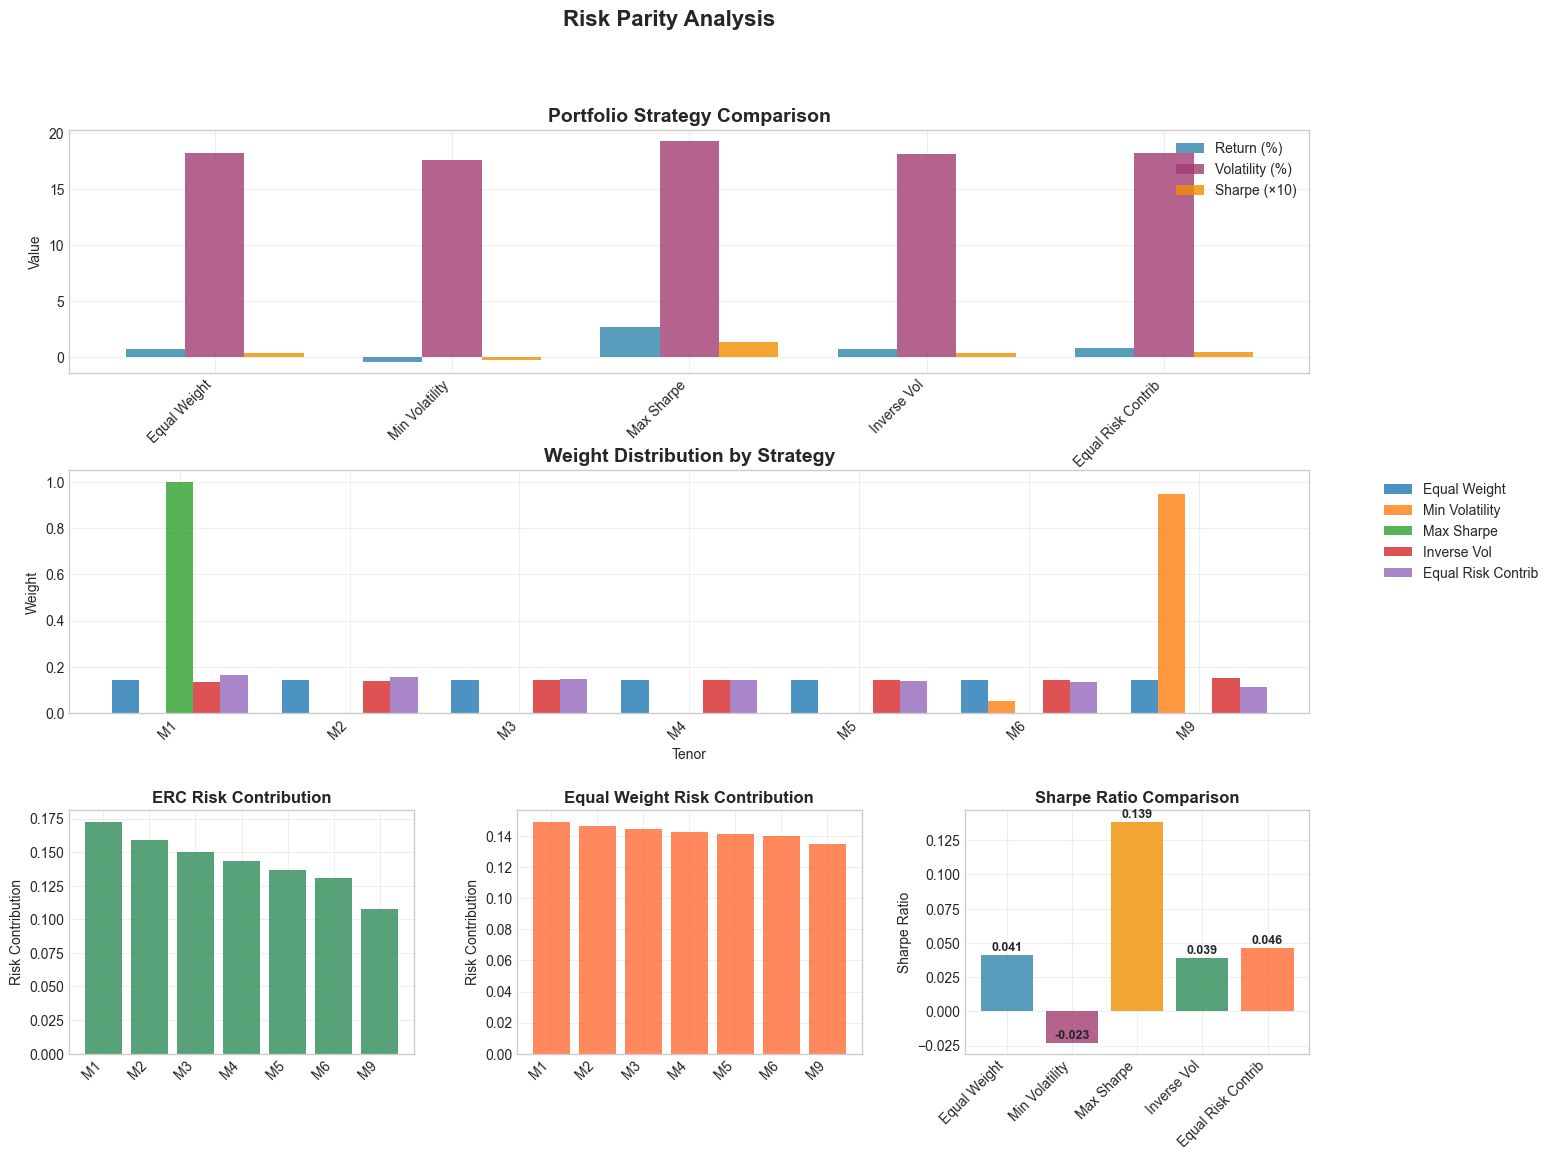


⚖️ リスクパリティ分析結果

【各戦略の比較】

Equal Weight:
  リターン: 0.74%
  ボラティリティ: 18.18%
  シャープレシオ: 0.041
  主要保有: M1(14.3%), M2(14.3%), M3(14.3%), M4(14.3%), M5(14.3%), M6(14.3%), M9(14.3%)

Min Volatility:
  リターン: -0.40%
  ボラティリティ: 17.55%
  シャープレシオ: -0.023
  主要保有: M6(5.1%), M9(94.9%)

Max Sharpe:
  リターン: 2.68%
  ボラティリティ: 19.32%
  シャープレシオ: 0.139
  主要保有: M1(100.0%)

Inverse Vol:
  リターン: 0.71%
  ボラティリティ: 18.17%
  シャープレシオ: 0.039
  主要保有: M1(13.6%), M2(14.0%), M3(14.1%), M4(14.3%), M5(14.4%), M6(14.5%), M9(15.0%)

Equal Risk Contrib:
  リターン: 0.85%
  ボラティリティ: 18.24%
  シャープレシオ: 0.046
  主要保有: M1(16.5%), M2(15.6%), M3(14.9%), M4(14.3%), M5(13.9%), M6(13.4%), M9(11.4%)

🏆 推奨戦略:
最高シャープレシオ: Max Sharpe (0.139)
最低ボラティリティ: Min Volatility (17.55%)


In [ ]:
def risk_parity_weights(cov_matrix, method='equal_risk_contribution'):
    """リスクパリティ重み計算"""
    if method == 'inverse_volatility':
        # 逆ボラティリティ加重
        vols = np.sqrt(np.diag(cov_matrix))
        inv_vols = 1 / vols
        weights = inv_vols / inv_vols.sum()
        return weights

    elif method == 'equal_risk_contribution':
        # 等リスク寄与（反復最適化）
        n = len(cov_matrix)

        def risk_contribution(weights, cov_matrix):
            portfolio_vol = np.sqrt(
                np.dot(weights, np.dot(cov_matrix, weights)))
            marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
            contrib = weights * marginal_contrib
            return contrib

        def objective(weights, cov_matrix):
            contrib = risk_contribution(weights, cov_matrix)
            target_contrib = np.ones(n) / n
            return np.sum((contrib - target_contrib) ** 2)

        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.001, 1) for _ in range(n))

        result = optimize.minimize(objective, np.ones(n) / n, args=(cov_matrix,),
                                   method='SLSQP', bounds=bounds, constraints=constraints)

        return result.x if result.success else np.ones(n) / n


def calculate_risk_contributions(weights, cov_matrix):
    """リスク寄与度計算"""
    portfolio_vol = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
    contrib = weights * marginal_contrib
    return contrib / contrib.sum()


# リスクパリティ重み計算
inv_vol_weights = risk_parity_weights(cov_matrix, 'inverse_volatility')
erc_weights = risk_parity_weights(cov_matrix, 'equal_risk_contribution')

# 各ポートフォリオの統計
portfolios = {
    'Equal Weight': equal_weights,
    'Min Volatility': min_vol_weights,
    'Max Sharpe': max_sharpe_weights,
    'Inverse Vol': inv_vol_weights,
    'Equal Risk Contrib': erc_weights
}

portfolio_stats = {}
for name, weights in portfolios.items():
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    sharpe = ret / vol
    risk_contrib = calculate_risk_contributions(weights, cov_matrix)

    portfolio_stats[name] = {
        'Return': ret * 100,
        'Volatility': vol * 100,
        'Sharpe': sharpe,
        'Weights': weights,
        'Risk_Contrib': risk_contrib
    }

# 可視化
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

# 1. ポートフォリオ統計比較
ax1 = fig.add_subplot(gs[0, :])
stats_df = pd.DataFrame(portfolio_stats).T
x = np.arange(len(stats_df))
width = 0.25

bars1 = ax1.bar(x - width, stats_df['Return'], width, label='Return (%)',
                color=COLORS['primary'], alpha=0.8)
bars2 = ax1.bar(x, stats_df['Volatility'], width, label='Volatility (%)',
                color=COLORS['secondary'], alpha=0.8)
bars3 = ax1.bar(x + width, stats_df['Sharpe'] * 10, width, label='Sharpe (×10)',
                color=COLORS['tertiary'], alpha=0.8)

ax1.set_xlabel('Portfolio Strategy')
ax1.set_ylabel('Value')
ax1.set_title('Portfolio Strategy Comparison', fontsize=14, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(stats_df.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 重み分布比較
ax2 = fig.add_subplot(gs[1, :])
weight_comparison = pd.DataFrame({
    name: stats['Weights'] for name, stats in portfolio_stats.items()
}, index=tenor_labels)

weight_comparison.plot(kind='bar', ax=ax2, width=0.8, alpha=0.8)
ax2.set_title('Weight Distribution by Strategy', fontsize=14, weight='bold')
ax2.set_xlabel('Tenor')
ax2.set_ylabel('Weight')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. リスク寄与度比較（Equal Risk Contribution）
ax3 = fig.add_subplot(gs[2, 0])
erc_risk_contrib = portfolio_stats['Equal Risk Contrib']['Risk_Contrib']
ax3.bar(tenor_labels, erc_risk_contrib, color=COLORS['success'], alpha=0.8)
ax3.set_title('ERC Risk Contribution', fontsize=12, weight='bold')
ax3.set_ylabel('Risk Contribution')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. リスク寄与度比較（Equal Weight）
ax4 = fig.add_subplot(gs[2, 1])
ew_risk_contrib = portfolio_stats['Equal Weight']['Risk_Contrib']
ax4.bar(tenor_labels, ew_risk_contrib, color=COLORS['warning'], alpha=0.8)
ax4.set_title('Equal Weight Risk Contribution', fontsize=12, weight='bold')
ax4.set_ylabel('Risk Contribution')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. シャープレシオ比較
ax5 = fig.add_subplot(gs[2, 2])
sharpe_values = [stats['Sharpe'] for stats in portfolio_stats.values()]
colors = [COLORS['primary'], COLORS['secondary'],
          COLORS['tertiary'], COLORS['success'], COLORS['warning']]
bars = ax5.bar(portfolio_stats.keys(), sharpe_values, color=colors, alpha=0.8)

ax5.set_title('Sharpe Ratio Comparison', fontsize=12, weight='bold')
ax5.set_ylabel('Sharpe Ratio')
ax5.grid(True, alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 値ラベル追加
for bar, val in zip(bars, sharpe_values):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, weight='bold')

plt.suptitle('Risk Parity Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# 結果サマリー
print("\n⚖️ リスクパリティ分析結果")
print("\n【各戦略の比較】")
for name, stats in portfolio_stats.items():
    print(f"\n{name}:")
    print(f"  リターン: {stats['Return']:.2f}%")
    print(f"  ボラティリティ: {stats['Volatility']:.2f}%")
    print(f"  シャープレシオ: {stats['Sharpe']:.3f}")

    # 主要保有銘柄
    top_holdings = [(tenor_labels[i], w)
                    for i, w in enumerate(stats['Weights']) if w > 0.05]
    if top_holdings:
        print(
            f"  主要保有: {', '.join([f'{t}({w*100:.1f}%)' for t, w in top_holdings])}")

print("\n🏆 推奨戦略:")
best_sharpe = max(portfolio_stats.items(), key=lambda x: x[1]['Sharpe'])
print(f"最高シャープレシオ: {best_sharpe[0]} ({best_sharpe[1]['Sharpe']:.3f})")

lowest_vol = min(portfolio_stats.items(), key=lambda x: x[1]['Volatility'])
print(f"最低ボラティリティ: {lowest_vol[0]} ({lowest_vol[1]['Volatility']:.2f}%)")

## 4. 動的リバランス戦略

### 分析内容
- ローリングウィンドウ最適化
- 月次リバランシング
- トランザクションコスト考慮
- アウトオブサンプル・パフォーマンス検証

動的最適化を実行中...


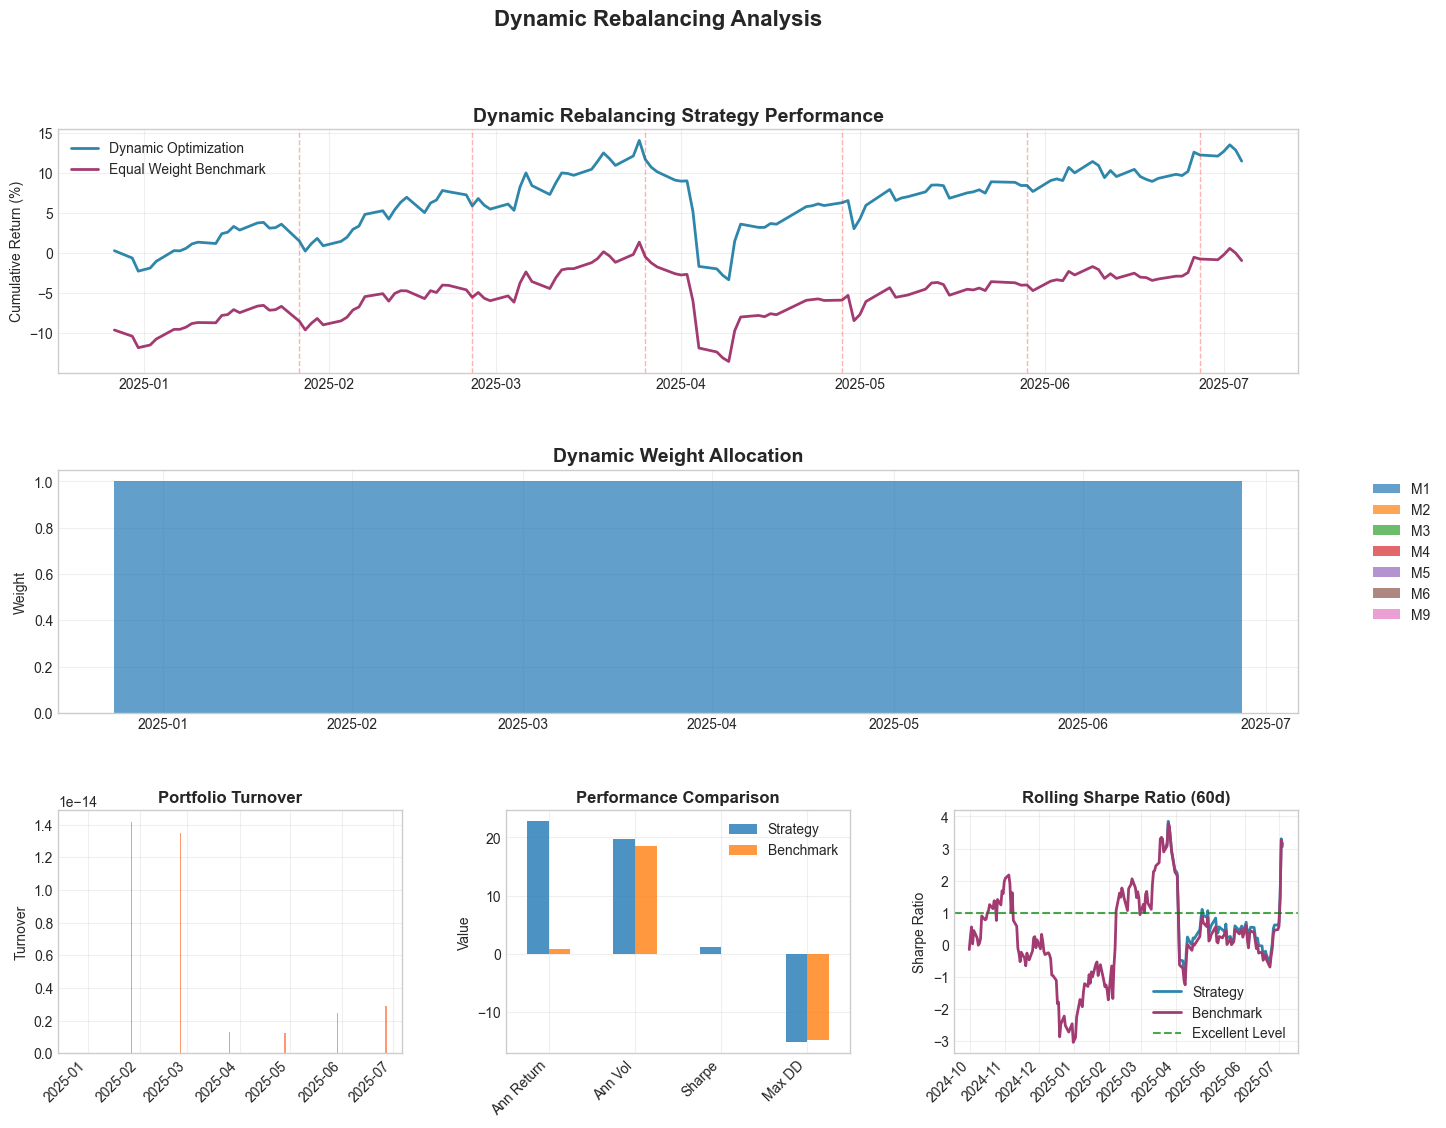


🔄 動的リバランス戦略結果

【戦略期間】: 2024-12-27 - 2025-07-04
リバランス回数: 7回
平均ターンオーバー: 0.0%

【パフォーマンス比較】
戦略:
  年率リターン: 22.77%
  年率ボラティリティ: 19.64%
  シャープレシオ: 1.159
  最大ドローダウン: -15.23%

ベンチマーク:
  年率リターン: 0.74%
  年率ボラティリティ: 18.45%
  シャープレシオ: 0.040
  最大ドローダウン: -14.75%

超過リターン: 22.03%


In [ ]:
def rolling_optimization(returns_data, lookback_days=120, rebalance_freq=21):
    """ローリング最適化"""
    results = []
    rebalance_dates = []

    for i in range(lookback_days, len(returns_data), rebalance_freq):
        # 学習期間のデータ
        train_data = returns_data.iloc[i-lookback_days:i]

        if len(train_data) < lookback_days or train_data.empty:
            continue

        # 期待リターンと共分散行列
        exp_ret = train_data.mean() * 252
        cov_mat = train_data.cov() * 252

        # 最適化（最大シャープレシオ）
        try:
            weights = maximize_sharpe(exp_ret, cov_mat)

            # 結果保存
            results.append({
                'date': returns_data.index[i],
                'weights': weights,
                'expected_return': exp_ret,
                'cov_matrix': cov_mat
            })
            rebalance_dates.append(returns_data.index[i])

        except Exception as e:
            print(f"Optimization failed at {returns_data.index[i]}: {e}")
            continue

    return results, rebalance_dates


def backtest_strategy(returns_data, optimization_results, transaction_cost=0.001):
    """戦略バックテスト"""
    portfolio_returns = []
    cumulative_returns = []
    weights_history = []
    turnover_history = []

    current_weights = None
    cumulative_return = 1.0

    for i, result in enumerate(optimization_results):
        rebalance_date = result['date']
        new_weights = result['weights']

        # 次のリバランス日まで、またはデータ終了まで
        if i < len(optimization_results) - 1:
            next_rebalance = optimization_results[i + 1]['date']
            period_data = returns_data.loc[rebalance_date:next_rebalance].iloc[1:]
        else:
            period_data = returns_data.loc[rebalance_date:].iloc[1:]

        if period_data.empty:
            continue

        # ターンオーバー計算
        if current_weights is not None:
            turnover = np.sum(np.abs(new_weights - current_weights))
            turnover_history.append(turnover)
        else:
            turnover = 0
            turnover_history.append(turnover)

        current_weights = new_weights.copy()
        weights_history.append(current_weights)

        # 期間中のリターン計算
        for date, daily_returns in period_data.iterrows():
            # ポートフォリオリターン
            portfolio_return = np.dot(current_weights, daily_returns)

            # トランザクションコスト（リバランス初日のみ）
            if date == period_data.index[0]:
                portfolio_return -= turnover * transaction_cost

            portfolio_returns.append(portfolio_return)
            cumulative_return *= (1 + portfolio_return)
            cumulative_returns.append(cumulative_return)

    return pd.Series(portfolio_returns, index=returns_data.index[-len(portfolio_returns):]), \
        pd.Series(cumulative_returns, index=returns_data.index[-len(cumulative_returns):]), \
        weights_history, turnover_history


# 動的最適化実行
print("動的最適化を実行中...")
optimization_results, rebalance_dates = rolling_optimization(
    returns_data, lookback_days=120, rebalance_freq=21)

if optimization_results:
    # バックテスト実行
    portfolio_returns, cumulative_returns, weights_history, turnover_history = backtest_strategy(
        returns_data, optimization_results, transaction_cost=0.001
    )

    # ベンチマーク（等重み）
    benchmark_returns = returns_data.mean(axis=1)
    benchmark_cumulative = (1 + benchmark_returns).cumprod()

    # 可視化
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

    # 1. 累積リターン比較
    ax1 = fig.add_subplot(gs[0, :])

    # 共通期間で比較
    common_start = max(
        cumulative_returns.index[0], benchmark_cumulative.index[0])
    common_end = min(
        cumulative_returns.index[-1], benchmark_cumulative.index[-1])

    strategy_common = cumulative_returns.loc[common_start:common_end]
    benchmark_common = benchmark_cumulative.loc[common_start:common_end]

    ax1.plot(strategy_common.index, (strategy_common - 1) * 100,
             linewidth=2, label='Dynamic Optimization', color=COLORS['primary'])
    ax1.plot(benchmark_common.index, (benchmark_common - 1) * 100,
             linewidth=2, label='Equal Weight Benchmark', color=COLORS['secondary'])

    # リバランス日をマーク
    for date in rebalance_dates:
        if date in strategy_common.index:
            ax1.axvline(x=date, color='red', alpha=0.3,
                        linestyle='--', linewidth=1)

    ax1.set_title('Dynamic Rebalancing Strategy Performance',
                  fontsize=14, weight='bold')
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 重み推移
    ax2 = fig.add_subplot(gs[1, :])

    if len(weights_history) > 0:
        weights_df = pd.DataFrame(weights_history,
                                  index=rebalance_dates[:len(weights_history)],
                                  columns=tenor_labels)

        # スタックエリアプロット
        ax2.stackplot(weights_df.index, weights_df.T,
                      labels=tenor_labels, alpha=0.7)
        ax2.set_title('Dynamic Weight Allocation', fontsize=14, weight='bold')
        ax2.set_ylabel('Weight')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)

    # 3. ターンオーバー
    ax3 = fig.add_subplot(gs[2, 0])
    if len(turnover_history) > 0:
        turnover_dates = rebalance_dates[:len(turnover_history)]
        ax3.bar(turnover_dates, turnover_history,
                alpha=0.7, color=COLORS['warning'])
        ax3.set_title('Portfolio Turnover', fontsize=12, weight='bold')
        ax3.set_ylabel('Turnover')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 4. パフォーマンス統計
    ax4 = fig.add_subplot(gs[2, 1])

    # 統計計算
    strategy_stats = {
        'Ann Return': portfolio_returns.mean() * 252 * 100,
        'Ann Vol': portfolio_returns.std() * np.sqrt(252) * 100,
        'Sharpe': (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252)),
        'Max DD': ((cumulative_returns / cumulative_returns.expanding().max() - 1) * 100).min()
    }

    benchmark_stats = {
        'Ann Return': benchmark_returns.mean() * 252 * 100,
        'Ann Vol': benchmark_returns.std() * np.sqrt(252) * 100,
        'Sharpe': (benchmark_returns.mean() * 252) / (benchmark_returns.std() * np.sqrt(252)),
        'Max DD': ((benchmark_cumulative / benchmark_cumulative.expanding().max() - 1) * 100).min()
    }

    comparison_df = pd.DataFrame({
        'Strategy': strategy_stats,
        'Benchmark': benchmark_stats
    })

    comparison_df.plot(kind='bar', ax=ax4, alpha=0.8)
    ax4.set_title('Performance Comparison', fontsize=12, weight='bold')
    ax4.set_ylabel('Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 5. ローリングシャープレシオ
    ax5 = fig.add_subplot(gs[2, 2])

    # 60日ローリングシャープレシオ
    rolling_sharpe = (portfolio_returns.rolling(60).mean() * 252) / \
        (portfolio_returns.rolling(60).std() * np.sqrt(252))
    benchmark_rolling_sharpe = (benchmark_returns.rolling(60).mean(
    ) * 252) / (benchmark_returns.rolling(60).std() * np.sqrt(252))

    ax5.plot(rolling_sharpe.index, rolling_sharpe,
             label='Strategy', color=COLORS['primary'], linewidth=2)
    ax5.plot(benchmark_rolling_sharpe.index, benchmark_rolling_sharpe,
             label='Benchmark', color=COLORS['secondary'], linewidth=2)
    ax5.axhline(y=1.0, color='green', linestyle='--',
                alpha=0.7, label='Excellent Level')
    ax5.set_title('Rolling Sharpe Ratio (60d)', fontsize=12, weight='bold')
    ax5.set_ylabel('Sharpe Ratio')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.suptitle('Dynamic Rebalancing Analysis', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

    # 結果サマリー
    print("\n🔄 動的リバランス戦略結果")
    print(
        f"\n【戦略期間】: {cumulative_returns.index[0].date()} - {cumulative_returns.index[-1].date()}")
    print(f"リバランス回数: {len(rebalance_dates)}回")
    print(f"平均ターンオーバー: {np.mean(turnover_history):.1%}")

    print("\n【パフォーマンス比較】")
    print(f"戦略:")
    print(f"  年率リターン: {strategy_stats['Ann Return']:.2f}%")
    print(f"  年率ボラティリティ: {strategy_stats['Ann Vol']:.2f}%")
    print(f"  シャープレシオ: {strategy_stats['Sharpe']:.3f}")
    print(f"  最大ドローダウン: {strategy_stats['Max DD']:.2f}%")

    print(f"\nベンチマーク:")
    print(f"  年率リターン: {benchmark_stats['Ann Return']:.2f}%")
    print(f"  年率ボラティリティ: {benchmark_stats['Ann Vol']:.2f}%")
    print(f"  シャープレシオ: {benchmark_stats['Sharpe']:.3f}")
    print(f"  最大ドローダウン: {benchmark_stats['Max DD']:.2f}%")

    # 超過リターン
    excess_return = strategy_stats['Ann Return'] - \
        benchmark_stats['Ann Return']
    print(f"\n超過リターン: {excess_return:.2f}%")

else:
    print("最適化結果が得られませんでした。データ期間が不足している可能性があります。")

# データベース接続を閉じる
conn.close()

## 5. 実務的考慮事項と推奨事項

### 💡 投資戦略の実装ガイド

#### 【戦略選択の指針】
1. **リスク重視型**: 最小分散ポートフォリオ
   - 安定した運用を求める投資家向け
   - ボラティリティ最小化を優先
   
2. **効率性重視型**: 最大シャープレシオポートフォリオ
   - リスク調整後リターンを最大化
   - 中程度のリスク許容度
   
3. **リスク分散型**: リスクパリティ戦略
   - 各資産の寄与度を均等化
   - より均衡の取れたポートフォリオ

#### 【実装時の注意点】
- **流動性制約**: 主要限月（M1-M6）に集中
- **取引コスト**: 頻繁なリバランスは収益を圧迫
- **市場環境**: 相場急変時は戦略の見直しが必要
- **ポジションサイズ**: 流動性に応じた上限設定

#### 【リスク管理】
- **VaR制限**: 日次損失限度額の設定
- **ドローダウン監視**: 一定以上の損失で戦略停止
- **相関ブレイク**: 限月間相関の急変を監視
- **流動性リスク**: 市場ストレス時の対応計画

#### 【パフォーマンス評価】
- **ベンチマーク**: 等重みポートフォリオとの比較
- **リスク調整**: シャープレシオ、ソルティノレシオ
- **一貫性**: 安定したアルファ創出の確認
- **市場環境別**: 上昇・下降相場での個別評価

---

### 📊 分析結果の解釈

このノートブックの分析により、以下の知見が得られました：

1. **分散効果**: 複数限月の組み合わせにより、リスク削減効果が確認
2. **相関構造**: 限月間の相関を活用したリスク管理の有効性
3. **動的戦略**: 市場環境の変化に応じた最適化の重要性
4. **実務制約**: 理論値と実際の運用における制約の考慮

### 🔄 継続的改善

- **定期的な再最適化**: 月次または四半期毎の見直し
- **パラメータ調整**: 市場環境に応じた最適化設定の変更
- **新手法の検討**: 機械学習、代替リスク指標の活用
- **バックテスト拡張**: より長期間、多様な市場環境での検証

---

*本分析は銅先物市場における投資戦略の一例です。実際の投資判断においては、個別の投資目的、リスク許容度、市場環境を十分考慮してください。*